## Importing necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
import pathlib
from pathlib import Path
from tqdm import tqdm

import cv2
import random
import shutil

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torch import nn
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image

from sklearn.model_selection import train_test_split

from PIL import Image, ImageChops, ImageEnhance

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Data Augmentation

### Set paths and create output directories

In [3]:
input_image_dir = "../Data/dataset/images"
input_masks_dir = "../Data/dataset/masks"

augmented_dir = "../Data/dataset/augmented"
augmented_images_dir = os.path.join(augmented_dir, "images")
augmented_masks_dir = os.path.join(augmented_dir, "masks")

os.makedirs(augmented_images_dir, exist_ok=True)
os.makedirs(augmented_masks_dir, exist_ok=True)

### Check if augmentation is already done

In [4]:
already_augmented = len(os.listdir(augmented_images_dir)) > 0

if already_augmented:
    print("Augmented images already exists. Skipping augmentation....")
else:
    print("No augmented images found. Proceeding with augmentaion....")

Augmented images already exists. Skipping augmentation....


### Augmentation transform

In [5]:
augmentation = [
    ("flip", transforms.RandomHorizontalFlip(p = 1.0)),
    ("rotate", transforms.RandomRotation(degrees = 15)),
    ("color_jitter", transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2))
]

### Apply augmentation and save output 

In [6]:
if not already_augmented:
    image_files = os.listdir(input_image_dir)

    for filename in tqdm(image_files, desc = "Augmenting images"):
        image_path = os.path.join(input_image_dir, filename)
        mask_path = os.path.join(input_masks_dir, filename)

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        for suffix, transform in augmentation:
            augmented_image = transform(image)

            #Don't apply color_jitter to mask
            if suffix == "color_jitter":
                augmented_mask = mask
            else:
                augmented_mask = transform(mask)

            # Save them with suffix
            base_name = os.path.splitext(filename)[0]
            image_save_path = os.path.join(augmented_images_dir, f"{base_name}_{suffix}.png")
            mask_save_path = os.path.join(augmented_masks_dir, f"{base_name}_{suffix}.png")

            augmented_image.save(image_save_path)
            augmented_mask.save(mask_save_path)

    print("Augmentation complete.")

### Visualizing the data

In [7]:
def plot_images_with_masks(image_dir, mask_dir, n=6, seed=None):
    """
    Plots images alongside their corresponding masks.

    Args:
        image_dir (str or Path): Directory containing the images.
        mask_dir (str or Path): Directory containing the masks (with same filenames).
        n (int): Number of image-mask pairs to display.
        seed (int): Optional random seed for reproducibility.
    """
    image_dir = Path(image_dir)
    mask_dir = Path(mask_dir)

    image_paths = list(image_dir.glob("*.png"))
    random.seed(seed)
    selected_images = random.sample(image_paths, k=n)

    plt.figure(figsize=(12, n * 2))

    for i, img_path in enumerate(selected_images):
        mask_path = mask_dir / img_path.name

        # Load image and mask
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") if mask_path.exists() else None

        # Plot image
        plt.subplot(n, 2, 2 * i + 1)
        plt.imshow(img)
        plt.title(f"Image: {img_path.name}")
        plt.axis("off")

        # Plot mask
        plt.subplot(n, 2, 2 * i + 2)
        if mask:
            plt.imshow(mask, cmap='gray')
            plt.title("Mask")
        else:
            plt.title("Mask not found")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


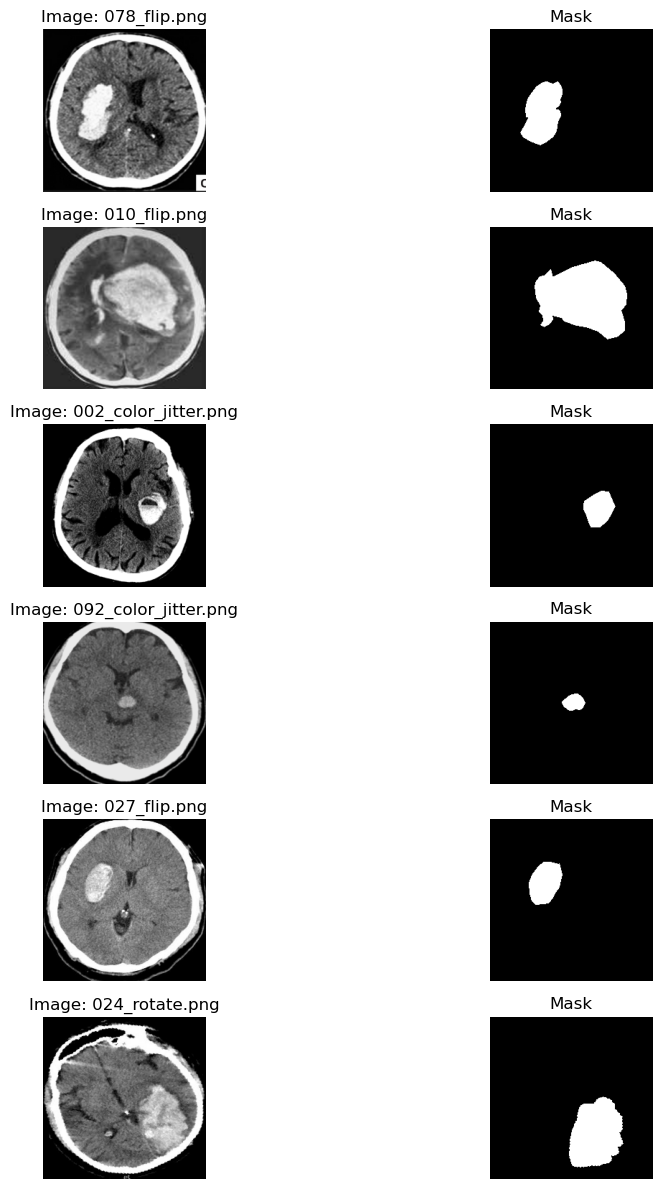

In [8]:
plot_images_with_masks(
    image_dir="../Data/dataset/augmented/images",
    mask_dir="../Data/dataset/augmented/masks",
    n=6,
    seed=42
)

In [9]:
image_path

NameError: name 'image_path' is not defined

In [10]:
shape_image = Image.open(image_path)
shape_image.size

NameError: name 'image_path' is not defined

## Make a custom Dataloader

In [3]:
def create_dataframe(image_dir, mask_dir):
    image_files = sorted(os.listdir(image_dir))
    mask_files = sorted(os.listdir(mask_dir))

    # Full paths
    image_paths = [os.path.join(image_dir, fname) for fname in image_files]
    mask_paths = [os.path.join(mask_dir, fname) for fname in mask_files]

    # Create dataframe
    df = pd.DataFrame({
        'image_path': image_paths,
        'mask_path': mask_paths
    })

    return df

# Example usage
train_df = create_dataframe("../Data/dataset/images", "../Data/dataset/masks")
test_df = create_dataframe("../Data/test_set/images", "../Data/test_set/mask")

In [4]:
class CTBrainSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=True):
        """
        Args:
            image_dir (str or Path): Path to images folder
            mask_dir (str or Path): Path to masks folder
            transform (bool): Apply default resize and normalization
        """
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.image_list = sorted(os.listdir(self.image_dir))
        self.mask_list = sorted(os.listdir(self.mask_dir))
        self.transform = transform

        assert len(self.image_list) == len(self.mask_list), \
            f"Mismatch: {len(self.image_list)} images and {len(self.mask_list)} masks."

        # Basic resizing transform
        self.image_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),                    #shape: [3, 256, 256]
        ])

        self.mask_transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.Grayscale(),                   
            transforms.ToTensor(),                    #shape: [1, 256, 256]
        ])

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = self.image_dir / self.image_list[idx]
        mask_path = self.mask_dir / self.mask_list[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # grayscale for mask

        if self.transform:
            image = self.image_transform(image)
            mask = self.mask_transform(mask)

        return image, mask

In [5]:
# Set the percentage of data to be used for training
train_ratio = 0.8

# Load full dataset
dataset = CTBrainSegmentationDataset(
    image_dir="../Data/dataset/images",
    mask_dir="../Data/dataset/masks"
)

In [6]:
image, mask = dataset[0]
image.shape, mask.shape

(torch.Size([3, 256, 256]), torch.Size([1, 256, 256]))

In [7]:
# Split sizes
train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

In [8]:
train_size, val_size

(52, 14)

In [9]:

# Split dataset
train_data, val_data = random_split(dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(train_data, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=8, shuffle=False)


In [10]:
len(train_dataloader), len(val_dataloader)

(7, 2)

In [11]:
# Inspect one batch
for images, masks in train_dataloader:
    print(f"Image batch shape: {images.shape}")  # [B, 3, 256, 256]
    print(f"Mask batch shape: {masks.shape}")    # [B, 1, 256, 256]
    break


Image batch shape: torch.Size([8, 3, 256, 256])
Mask batch shape: torch.Size([8, 1, 256, 256])


## U-Net Architecture PyTorch

In [17]:
import segmentation_models_pytorch as smp

# Define the model
model = smp.Unet(
    encoder_name="resnet34",        # or "efficientnet-b0", etc.
    encoder_weights="imagenet",     # use pretrained ImageNet weights
    in_channels=3,                  # RGB images
    classes=1,                      # Binary segmentation (output = 1 channel)
    activation=None                 # we'll apply activation manually
).to(device)


In [18]:
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Setup loss functions `Dice()`, `BCE()`, `IoU()`

In [14]:
smooth = 1e-3  # Same as your 0.001

# Dice Coefficient
def dice_coef(y_true, y_pred, smooth=smooth):
    y_true = y_true.contiguous().view(-1)
    y_pred = y_pred.contiguous().view(-1)

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum()

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

# Dice Loss
class DiceLoss(nn.Module):
    def __init__(self, smooth=smooth):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        y_pred = torch.sigmoid(y_pred)  # If using logits
        return 1 - dice_coef(y_true, y_pred, self.smooth)

# BCE + Dice Loss
class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=smooth):
        super(BCEDiceLoss, self).__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss(smooth)

    def forward(self, y_pred, y_true):
        bce_loss = self.bce(y_pred, y_true)
        dice_loss = self.dice(y_pred, y_true)
        return bce_loss + dice_loss

# IoU (Jaccard Index)
def iou_score(y_true, y_pred, smooth=smooth):
    y_true = y_true.contiguous().view(-1)
    y_pred = y_pred.contiguous().view(-1)
    y_pred = torch.sigmoid(y_pred)  # if using logits
    y_pred = (y_pred > 0.5).float()

    intersection = (y_true * y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    union = total - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou


### Trying a forward pass on single image

In [15]:
image_batch, mask_batch = next(iter(train_dataloader))
image_batch, mask_batch = image_batch.to(device), mask_batch.to(device)
print(f"Image shape: {image_batch.shape}")
print(f"Label shape: {mask_batch.shape}")

Image shape: torch.Size([8, 3, 256, 256])
Label shape: torch.Size([8, 1, 256, 256])


In [19]:
model(image_batch)

tensor([[[[ 1.0378,  0.8152,  0.9998,  ...,  0.3235,  0.1047,  0.0805],
          [ 2.1852,  1.5276,  1.6538,  ...,  1.6694,  1.0404,  0.5469],
          [ 1.2775,  1.1104,  1.1639,  ...,  1.2783,  0.5038,  0.4178],
          ...,
          [ 1.1269,  0.1107,  0.4245,  ...,  1.0114,  0.6158,  0.9999],
          [ 0.6584,  0.0650,  0.8633,  ...,  0.7721,  0.7026,  0.8519],
          [ 0.3984, -0.2743,  0.4653,  ...,  0.1885,  0.0524,  0.1855]]],


        [[[ 1.1585,  0.7199,  0.3226,  ...,  0.2117, -0.2424, -0.1427],
          [ 2.0876,  1.4538,  1.4636,  ...,  0.8141,  0.4334,  0.3504],
          [ 1.9390,  1.3035,  1.1124,  ...,  0.8351,  0.5451,  0.4800],
          ...,
          [ 0.7792, -0.4463, -0.1250,  ...,  0.6609,  0.1807,  0.1661],
          [ 0.5048, -0.1032,  0.4028,  ...,  0.6152,  0.5313,  0.3957],
          [ 0.3077, -0.0849,  0.6340,  ...,  0.2111,  0.4020,  0.2896]]],


        [[[ 0.9756,  0.4410,  0.3845,  ...,  0.1073, -0.0688, -0.0095],
          [ 1.9662,  0.806

### Create a train and test loop

In [37]:
def calculate_dice(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return dice.item()

def calculate_iou(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds)
    preds = (preds > 0.5).float()

    preds = preds.view(-1)
    targets = targets.view(-1)

    intersection = (preds * targets).sum()
    union = preds.sum() + targets.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou.item()


In [ ]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss, train_acc, total_dice, total_iou = 0, 0, 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y = y.float()

        y_logits = model(X)
        loss = loss_fn(y_logits, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred = torch.sigmoid(y_logits) > 0.5
        train_acc += (y_pred == y).sum().item() / y.numel()

        total_dice += calculate_dice(y_logits, y)
        total_iou += calculate_iou(y_logits, y)

    return (
        train_loss / len(dataloader),
        train_acc / len(dataloader),
        total_dice / len(dataloader),
        total_iou / len(dataloader)
    )


In [ ]:
def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss, test_acc, total_dice, total_iou = 0, 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y = y.float()

            y_logits = model(X)
            loss = loss_fn(y_logits, y)
            test_loss += loss.item()

            y_pred = torch.sigmoid(y_logits) > 0.5
            test_acc += (y_pred == y).sum().item() / y.numel()

            total_dice += calculate_dice(y_logits, y)
            total_iou += calculate_iou(y_logits, y)

    return (
        test_loss / len(dataloader),
        test_acc / len(dataloader),
        total_dice / len(dataloader),
        total_iou / len(dataloader)
    )



### Create a `train()` function to combine `train_step()` and `test_step()`

In [ ]:
from tqdm import tqdm
def train(model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, device):
    results = {"train_loss": [], "train_acc": [], "train_dice": [], "train_iou": [],
               "val_loss": [], "val_acc": [], "val_dice": [], "val_iou": []}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_dice, train_iou = train_step(
            model, train_dataloader, loss_fn, optimizer, device
        )

        val_loss, val_acc, val_dice, val_iou = test_step(
            model, val_dataloader, loss_fn, device
        )

        print(f"Epoch: {epoch+1:02d} | "
              f"Train_loss: {train_loss:.4f} | Train_acc: {train_acc:.4f} | "
              f"Train_dice: {train_dice:.4f} | Train_iou: {train_iou:.4f} || "
              f"Val_loss: {val_loss:.4f} | Val_acc: {val_acc:.4f} | "
              f"Val_dice: {val_dice:.4f} | Val_iou: {val_iou:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_dice"].append(train_dice)
        results["train_iou"].append(train_iou)

        results["val_loss"].append(val_loss)
        results["val_acc"].append(val_acc)
        results["val_dice"].append(val_dice)
        results["val_iou"].append(val_iou)

    return results


### Train and evaluate model

In [52]:
torch.manual_seed(42)

NUM_EPOCHS = 10
loss_fn = BCEDiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

from timeit import default_timer as timer

start_time = timer()

model_0_results = train(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=NUM_EPOCHS,
    device=device,
)

end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds.")

 10%|█         | 1/10 [00:01<00:10,  1.16s/it]

Epoch: 01 | Train_loss: 0.8981 | Train_acc: 0.9889 | Train_dice: 0.9463 | Train_iou: 0.8983 || Val_loss: 0.8510 | Val_acc: 0.9725 | Val_dice: 0.8775 | Val_iou: 0.7822


 20%|██        | 2/10 [00:02<00:07,  1.02it/s]

Epoch: 02 | Train_loss: 0.9028 | Train_acc: 0.9877 | Train_dice: 0.9343 | Train_iou: 0.8770 || Val_loss: 0.8274 | Val_acc: 0.9783 | Val_dice: 0.9066 | Val_iou: 0.8292


 30%|███       | 3/10 [00:02<00:06,  1.09it/s]

Epoch: 03 | Train_loss: 0.8804 | Train_acc: 0.9894 | Train_dice: 0.9502 | Train_iou: 0.9053 || Val_loss: 0.8280 | Val_acc: 0.9752 | Val_dice: 0.8930 | Val_iou: 0.8067


 40%|████      | 4/10 [00:03<00:05,  1.11it/s]

Epoch: 04 | Train_loss: 0.8827 | Train_acc: 0.9877 | Train_dice: 0.9333 | Train_iou: 0.8752 || Val_loss: 0.7891 | Val_acc: 0.9804 | Val_dice: 0.9185 | Val_iou: 0.8493


 50%|█████     | 5/10 [00:04<00:04,  1.14it/s]

Epoch: 05 | Train_loss: 0.8639 | Train_acc: 0.9901 | Train_dice: 0.9553 | Train_iou: 0.9146 || Val_loss: 0.7901 | Val_acc: 0.9772 | Val_dice: 0.9031 | Val_iou: 0.8236


 60%|██████    | 6/10 [00:05<00:03,  1.15it/s]

Epoch: 06 | Train_loss: 0.8577 | Train_acc: 0.9888 | Train_dice: 0.9421 | Train_iou: 0.8908 || Val_loss: 0.7785 | Val_acc: 0.9783 | Val_dice: 0.9078 | Val_iou: 0.8313


 70%|███████   | 7/10 [00:06<00:02,  1.15it/s]

Epoch: 07 | Train_loss: 0.8424 | Train_acc: 0.9907 | Train_dice: 0.9568 | Train_iou: 0.9175 || Val_loss: 0.7751 | Val_acc: 0.9784 | Val_dice: 0.9092 | Val_iou: 0.8336


 80%|████████  | 8/10 [00:07<00:01,  1.16it/s]

Epoch: 08 | Train_loss: 0.8224 | Train_acc: 0.9896 | Train_dice: 0.9513 | Train_iou: 0.9075 || Val_loss: 0.7589 | Val_acc: 0.9798 | Val_dice: 0.9148 | Val_iou: 0.8430


 90%|█████████ | 9/10 [00:08<00:00,  1.16it/s]

Epoch: 09 | Train_loss: 0.8351 | Train_acc: 0.9902 | Train_dice: 0.9483 | Train_iou: 0.9022 || Val_loss: 0.7518 | Val_acc: 0.9785 | Val_dice: 0.9091 | Val_iou: 0.8333


100%|██████████| 10/10 [00:08<00:00,  1.13it/s]

Epoch: 10 | Train_loss: 0.8178 | Train_acc: 0.9905 | Train_dice: 0.9545 | Train_iou: 0.9133 || Val_loss: 0.7415 | Val_acc: 0.9798 | Val_dice: 0.9154 | Val_iou: 0.8439
Total training time: 8.857 seconds.


## Plot loss curves

In [ ]:
def plot_loss_curves(results):
    """
    Plots training and validation metrics: loss, accuracy, Dice score, and IoU
    from a results dictionary.

    Args:
        results (dict): Dictionary containing lists for each metric per epoch.
                        Keys:
                        - "train_loss", "val_loss"
                        - "train_acc", "val_acc"
                        - "train_dice", "val_dice"
                        - "train_iou", "val_iou"
    """
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(20, 15))

    # 1. Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, results["train_loss"], label="Train Loss")
    plt.plot(epochs, results["val_loss"], label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)

    # 2. Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(epochs, results["train_acc"], label="Train Accuracy")
    plt.plot(epochs, results["val_acc"], label="Val Accuracy")
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)

    # 3. Dice Score
    plt.subplot(2, 2, 3)
    plt.plot(epochs, results["train_dice"], label="Train Dice")
    plt.plot(epochs, results["val_dice"], label="Val Dice")
    plt.title("Dice Score over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Dice Score")
    plt.legend()
    plt.grid(True)

    # 4. IoU
    plt.subplot(2, 2, 4)
    plt.plot(epochs, results["train_iou"], label="Train IoU")
    plt.plot(epochs, results["val_iou"], label="Val IoU")
    plt.title("IoU over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


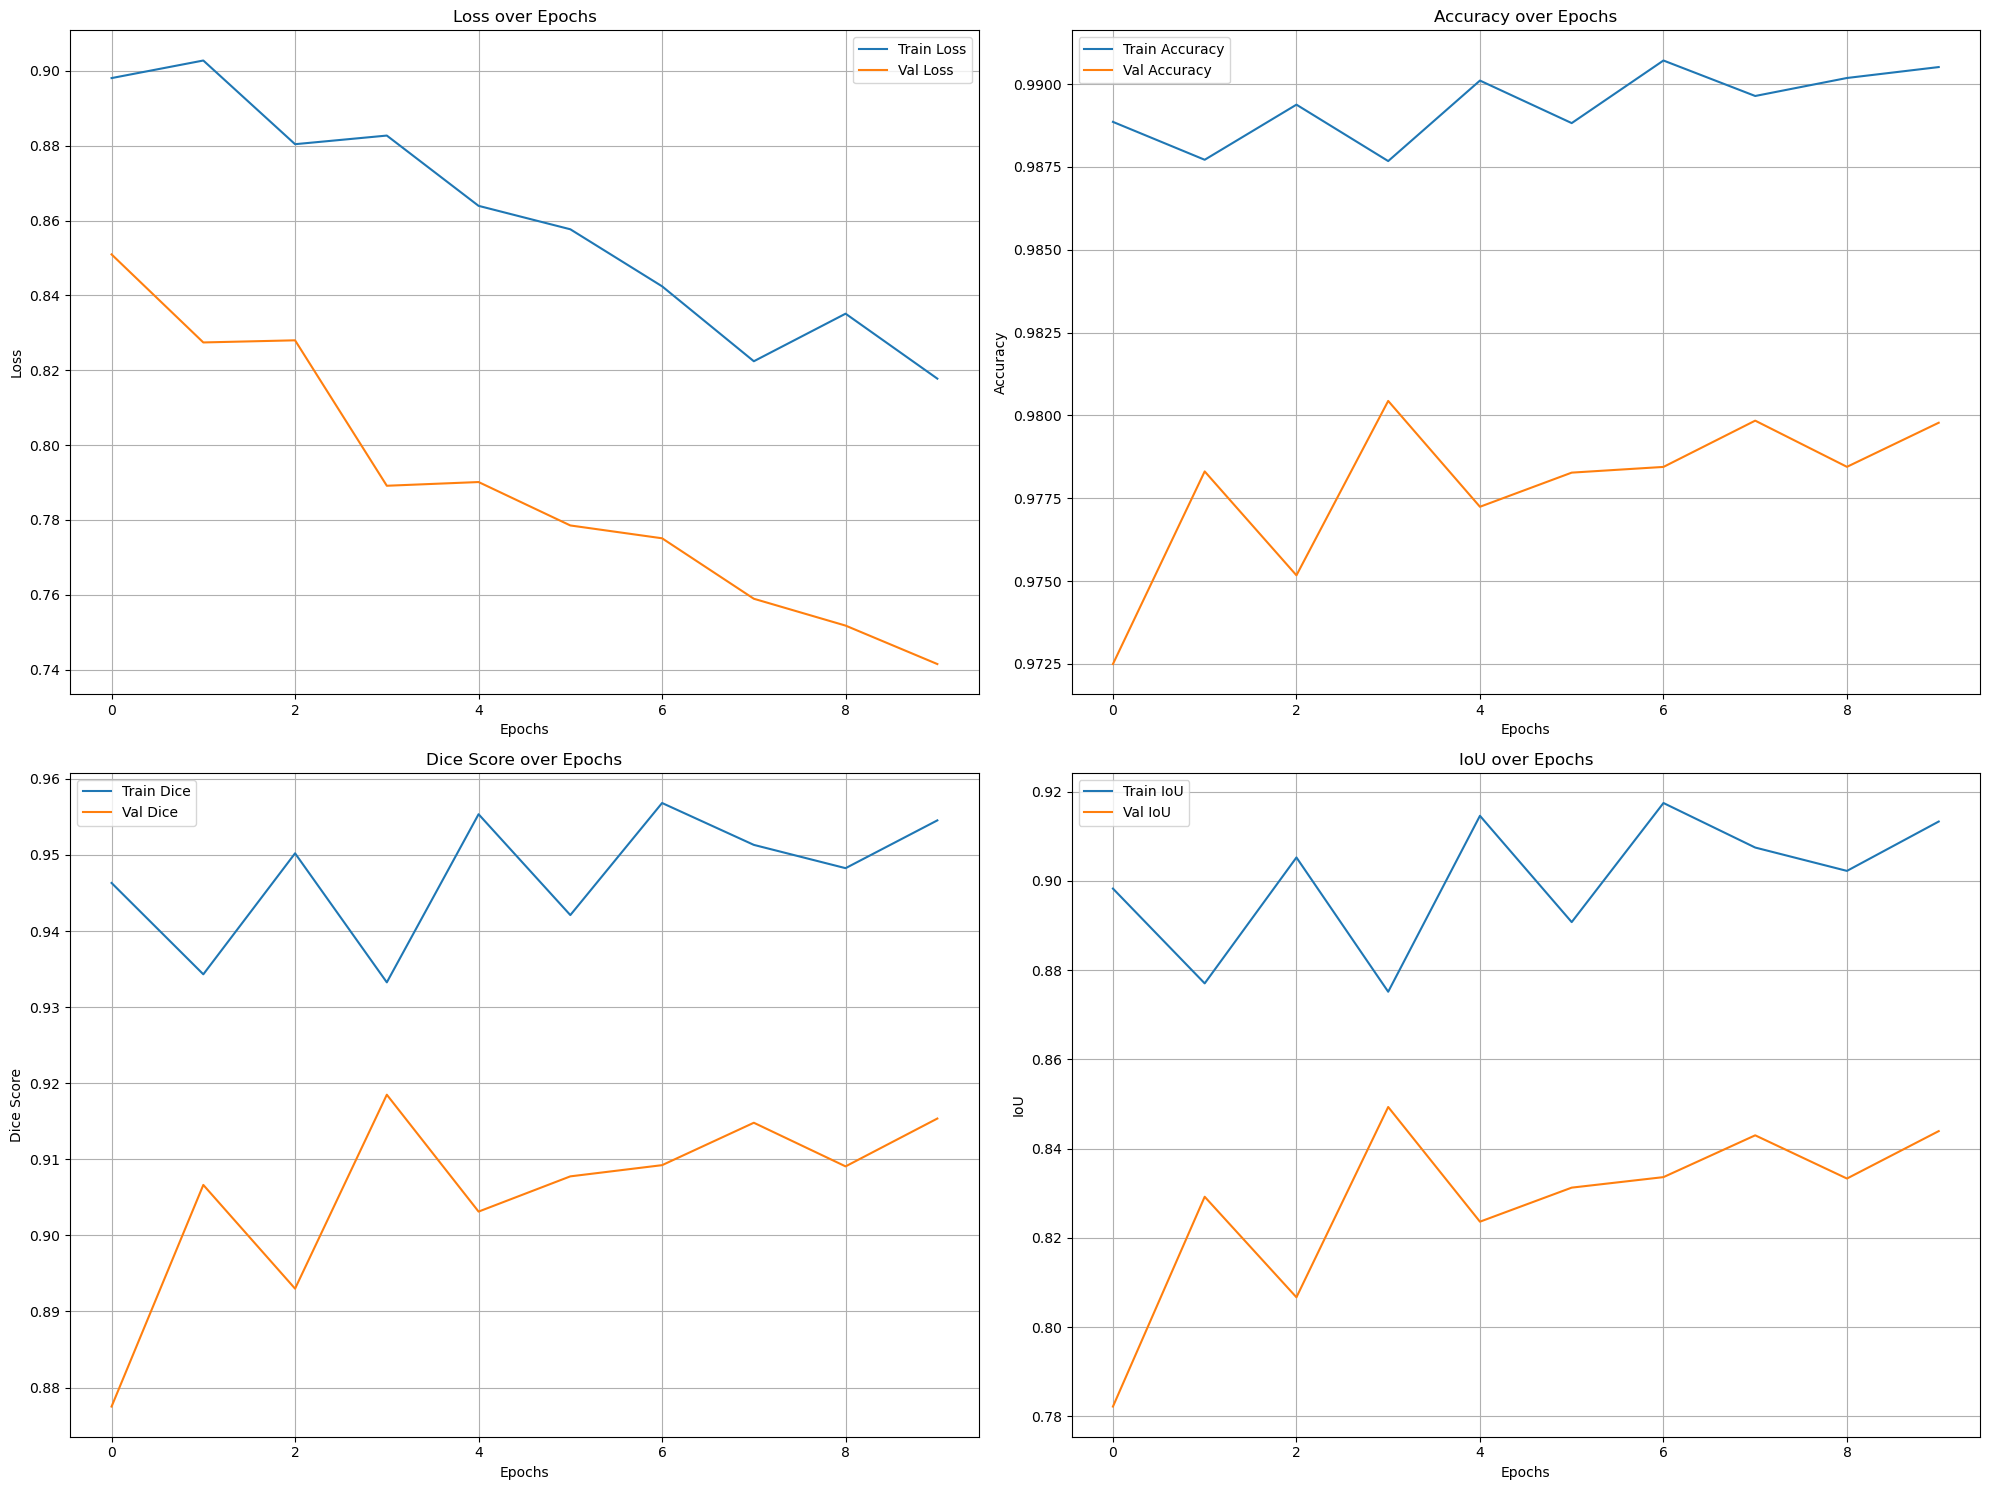

In [56]:
plot_loss_curves(model_0_results)


## Results on test_set (Ground Truth vs Predicted masks)

Inference for image 0


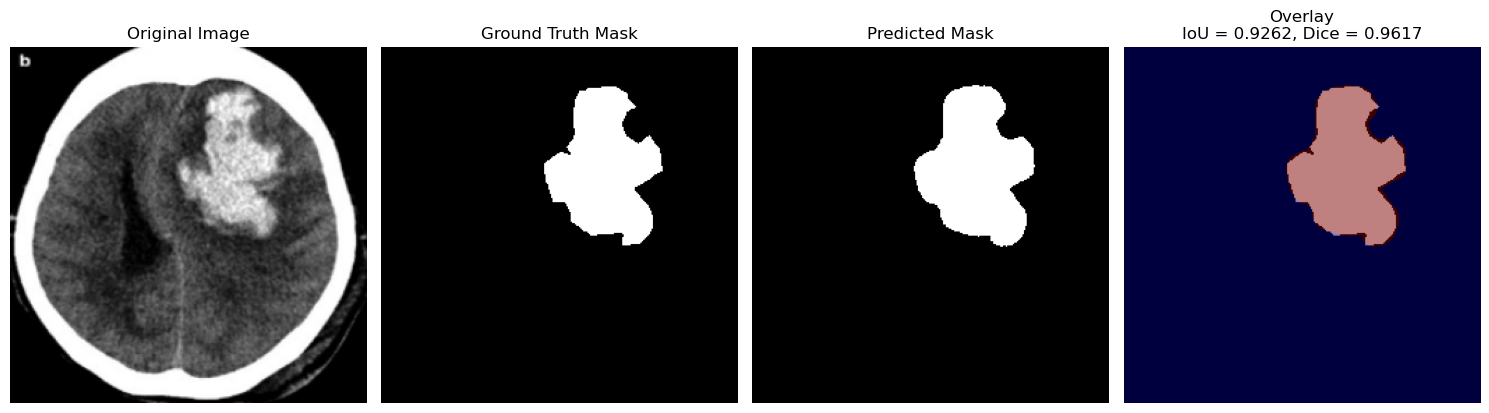

Inference for image 1


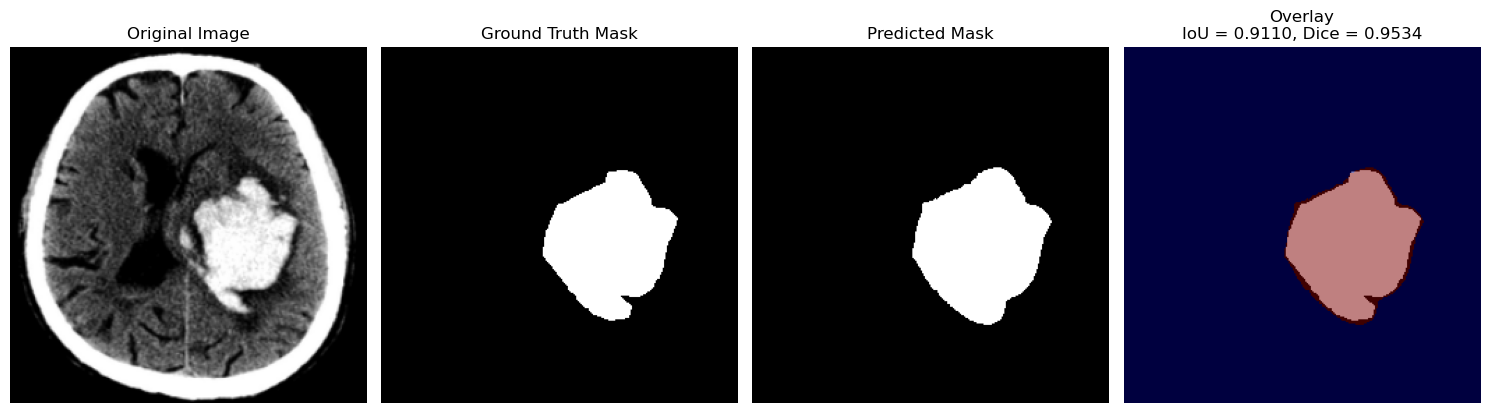

Inference for image 2


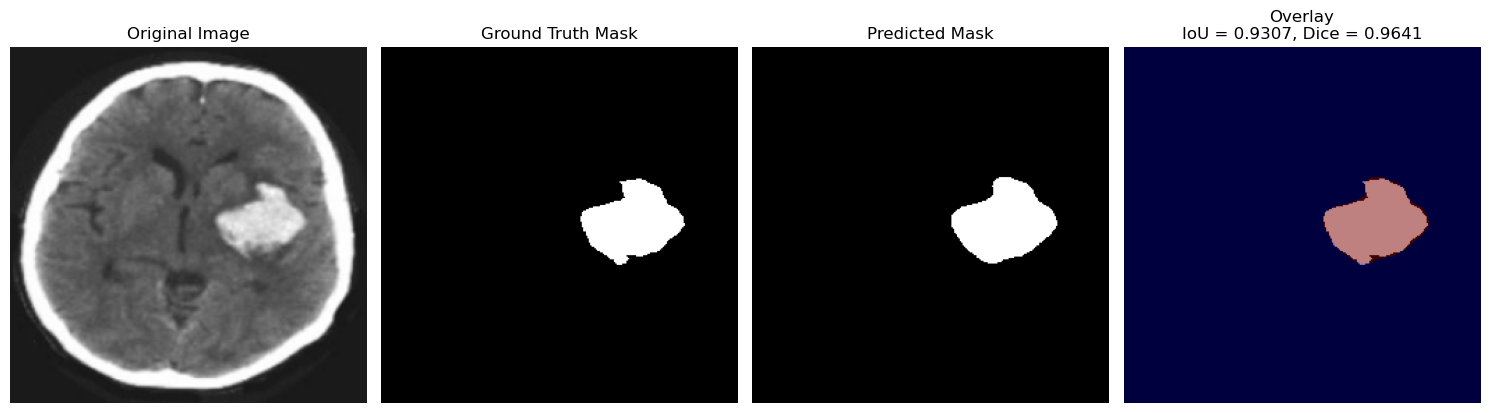

Inference for image 3


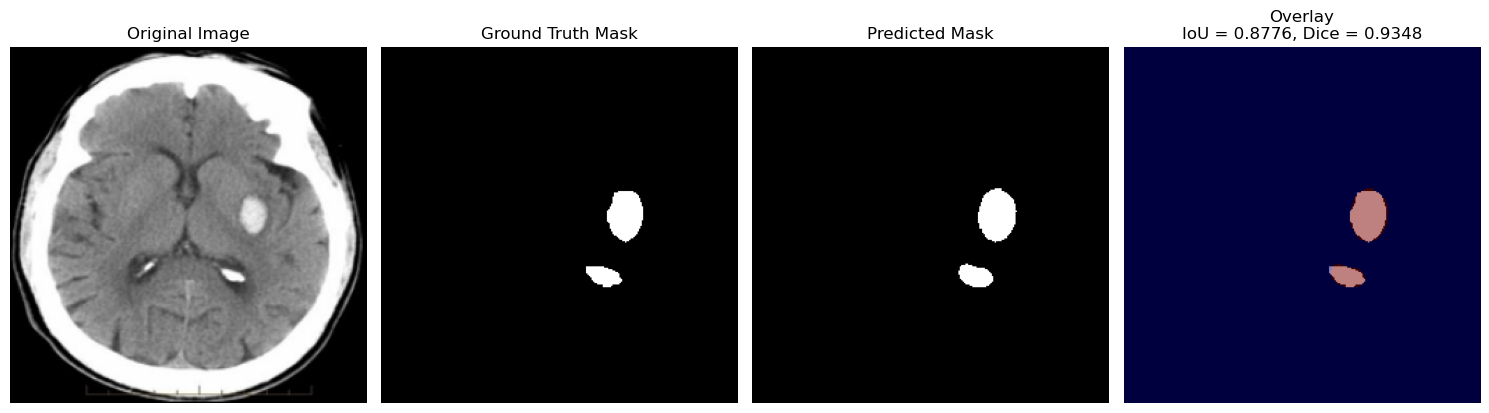

Inference for image 4


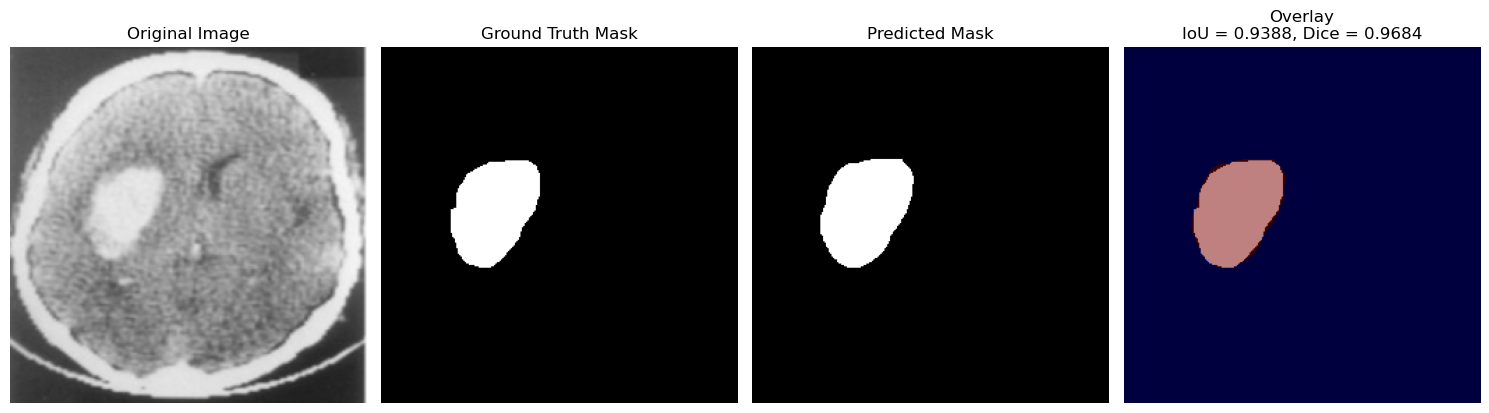

Inference for image 5


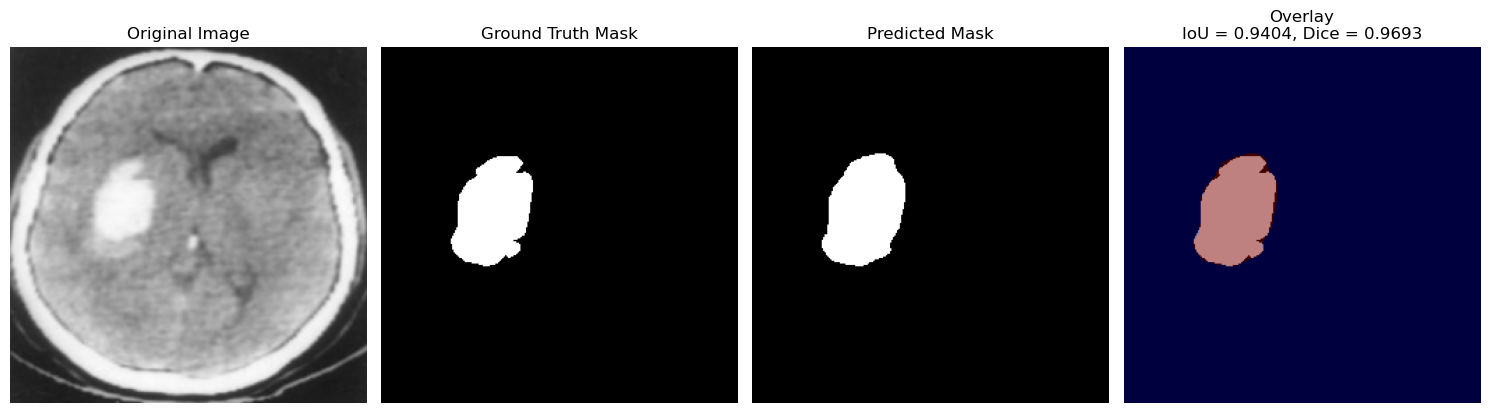

Inference for image 6


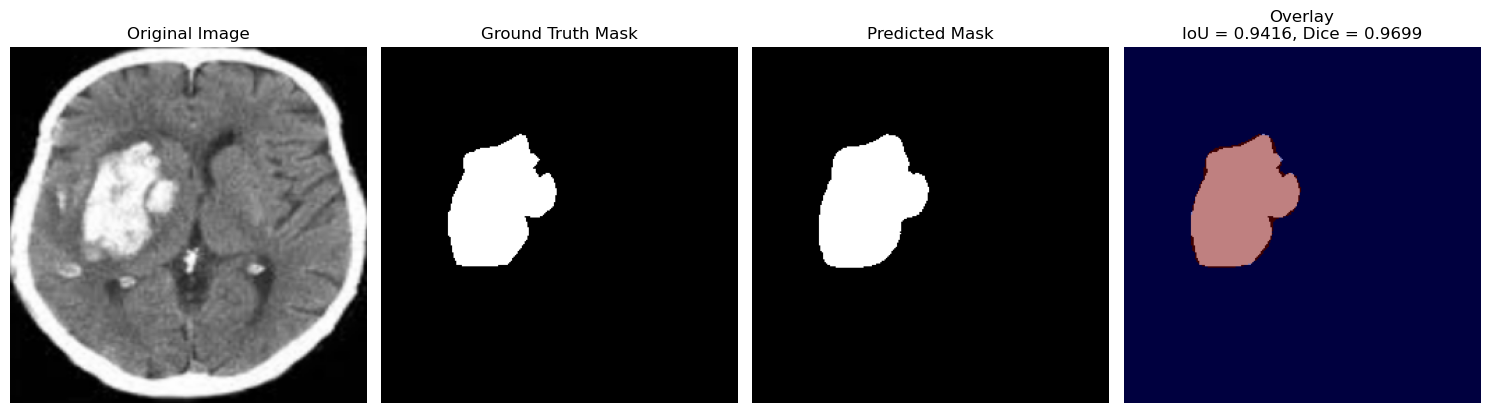

Inference for image 7


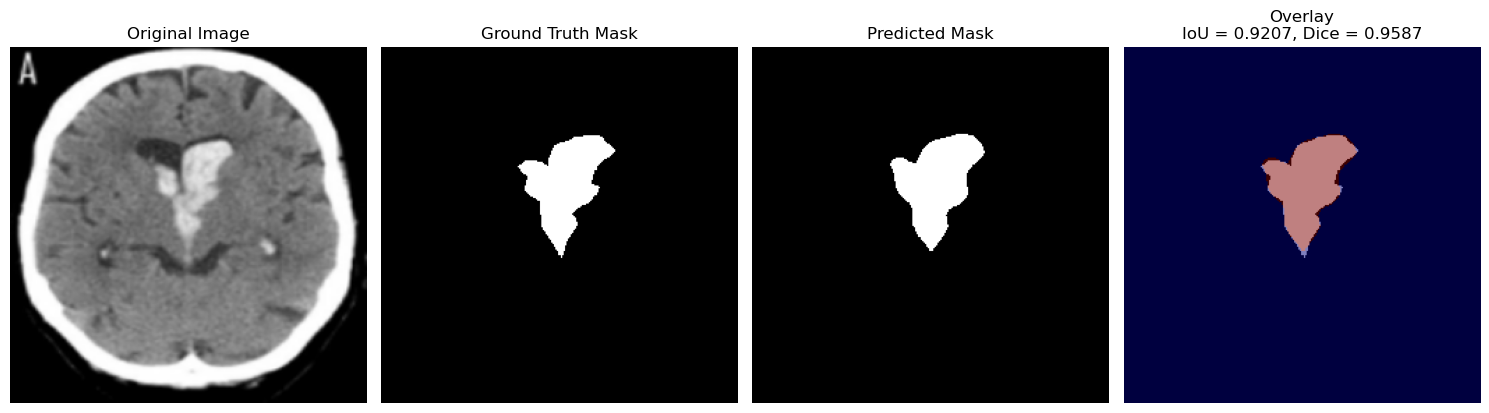

Inference for image 8


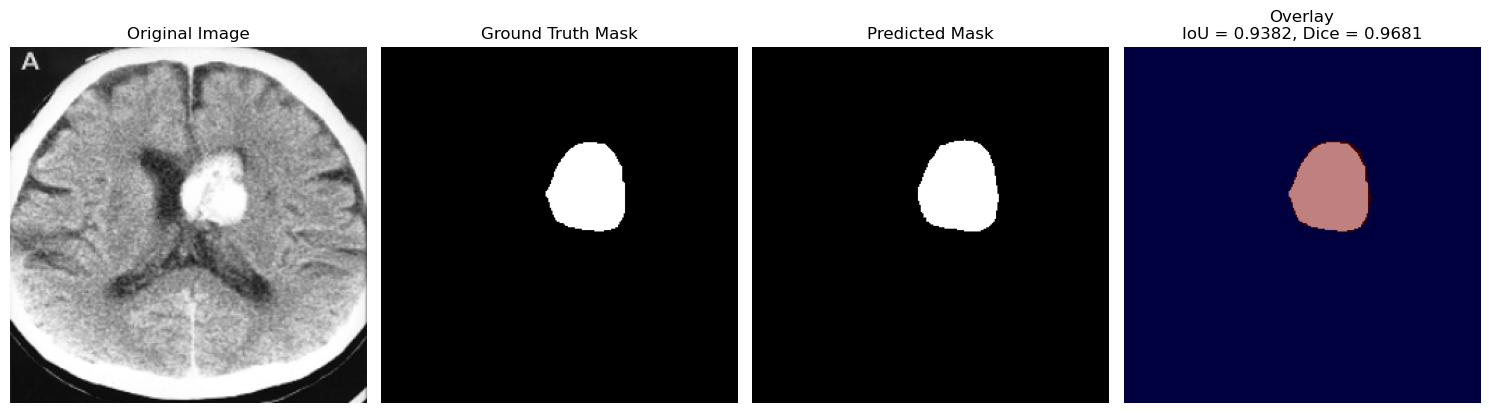

Inference for image 9


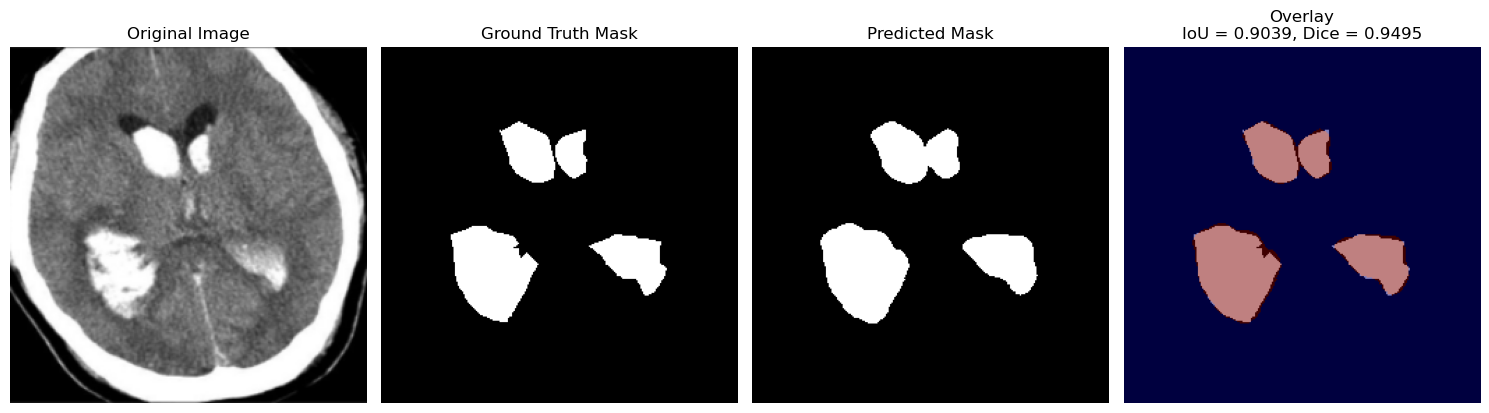

In [57]:
IMAGE_SIZE = (256, 256)  # Example, change this to your model's input size
def dice_coef(pred, target, smooth=1e-7):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_coef(pred, target, smooth=1e-7):
    pred = pred.flatten()
    target = target.flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

# Define image transformation
transform = transforms.Compose([
    transforms.ToTensor()
])

model.eval()
pred_list = []
true_list = []

for i in range(10):
    print(f"Inference for image {i}")
    
    # Load and preprocess image
    img_path = test_df['image_path'].iloc[i]
    img = cv2.imread(img_path)
    img = cv2.resize(img, IMAGE_SIZE)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    input_tensor = transform(img).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(input_tensor)
        pred_mask = torch.sigmoid(output).cpu().squeeze().numpy()
        pred_mask_bin = (pred_mask >= 0.5).astype(np.uint8)

    # Load and preprocess ground truth mask
    mask_path = test_df['mask_path'].iloc[i]
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.resize(gt_mask, IMAGE_SIZE)
    gt_mask_bin = (gt_mask > 127).astype(np.uint8)

    # Calculate scores
    dice = dice_coef(pred_mask_bin, gt_mask_bin)
    iou = iou_coef(pred_mask_bin, gt_mask_bin)

    pred_list.append(pred_mask_bin)
    true_list.append(gt_mask_bin)

    # Plotting
    plt.figure(figsize=(15, 20))

    plt.subplot(1, 4, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(gt_mask_bin, cmap='gray')
    plt.title('Ground Truth Mask')
    plt.axis('off')

    plt.subplot(1, 4, 3)
    plt.imshow(pred_mask_bin, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.subplot(1, 4, 4)
    plt.imshow(gt_mask_bin, cmap='gray')
    plt.imshow(pred_mask_bin, cmap='jet', alpha=0.5)
    plt.title(f'Overlay\nIoU = {iou:.4f}, Dice = {dice:.4f}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()
